# Tutorial: Differentiable Modeling and **δHBV 1.0**

---

This notebook gives detailed demonstration of training and forward simulation with the δHBV 1.0 model developed by [Dapeng Feng et al. (2022)](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2022WR032404). A pre-trained model is provided for those who only wish to run the model forward.

For explanation of model structure, methodologies, data, and performance metrics, please refer to Feng's publication [below](#publication). If you find this code is useful in your own work, please include the aforementioned citation.

*Note: We include some discussion of differentiable modeling methodology, and recommend this notebook as a starting point for an operational understanding of the dMG framework*

<br>

### Before Running:
- **Environment**: See [setup.md](./../../docs/setup.md) for ENV setup. dMG must be installed with dependencies + hydroDL2 to run this notebook.

- **Model**: Download pretrained δHBV 1.0 model weights from [AWS](https://mhpi-spatial.s3.us-east-2.amazonaws.com/mhpi-release/models/dHBV_1_0_trained.zip). Then update the model config:

    - In [`./generic_deltamodel/example/conf/config_dhbv_1_0.yaml`](./../conf/config_dhbv_1_0.yaml), update *trained_model* with your path to the parent directory containing both trained model weights `dHBV_1_0_Ep50.pt` (or *Ep100*) **and** normalization file `normalization_statistics.json`.

- **Data**: Download the CAMELS data extraction from [AWS](https://mhpi-spatial.s3.us-east-2.amazonaws.com/mhpi-release/camels/camels_data.zip). Then, updated the data configs:

    - In [`./generic_deltamodel/example/conf/observations/camels_531.yaml`](./../conf/observations/camels_531.yaml) and [`camels_671.yaml`](./../conf/observations/camels_671.yaml), update...
        1. *train_path* with `training_file` path,
        2. *test_path* with `validation file` path,
        3. *gage_info* with `gage_ids.npy` path,
        4. *subset_path* with `531_subset.txt` path (camels_531 only).

- **Hardware**: The NNs used in this model require CUDA support only available with Nvidia GPUs. For those without access, T4 GPUs can be used when running this notebook with dMG on [Google Colab](https://colab.research.google.com/).

### Publication:

*Dapeng Feng, Jiangtao Liu, Kathryn Lawson, Chaopeng Shen. "Differentiable, Learnable, Regionalized Process‐Based Models With Multiphysical Outputs can Approach State‐Of‐The‐Art Hydrologic Prediction Accuracy." Water Resources Research 58, no. 10 (2022): e2022WR032404. https://doi.org/10.1029/2022WR032404.*

<br>

### Issues:
For questions, concerns, bugs, etc., please reach out by posting an [issue](https://github.com/mhpi/generic_deltaModel/issues).

---


<br>

## Differentiable Modeling

In general, differentiable modeling represents the coupling of a neural network and a (differentiable) physical model. This enables several capabilities, like introducing missing processses and bias corrections. In the applications of these notebooks, we demonstrate the parameter learning modality;

Physics models include parameters for which True values are seldom known, but can be approximated with various methods. By coupling a neural network (NN), we can learn a set of a physical model's parameters (static or dynamic in, e.g., time), which can then be passed alongside other input variables to the physical model for making predictions.

For δHBV 1.0, we use an LSTM NN in concert with the physical model HBV (Beck 2020; Seibert 2005). HBV uses input forcing (time-varying) variables precipitation, temperature, and potential evapotranspiration (PET) across a collection of hydrologic basins, with physical parameters learned at the same spatiotemporal resolution [timesteps, basins], to make predictions about hydrologic states and fluxes (e.g., streamflow in our case) in both space and time. In general, this differentiable model takes the form

$
\delta \text{HBV} = 
\begin{cases}
P = \text{LSTM}(X \text{, \ } A) \\
Q \text{, \ } \mu = \text{HBV}(X \text{, \ } P)
\end{cases}
$

where
- \( $P$ \) the physical parameters used in HBV's equations, learned by a NN;
- \( $X$ \) represents input weather forcings;
- \( $A$ \) is the set of static basin attributes. (This could be any other static data correlated with $P$);
- \( $Q, \mu$ \) these are the fluxes and states, respectively, that the physical model can output.

Currently, δHBV is trained to make **streamflow** predictions, but it can be reconfigured without much effort to predict percolation, recharge, and groundwater flow, among others.

After showing an example implementation, we will demonstrate how to train the model and expose critical details of the process.

---


## 1. Create and Forward δHBV 1.0

After completing [these](#before-running) steps (model file not needed), δHBV 1.0 can be built with the code cells [below](#13-demonstration), where we illustrate the model creation process in detail.

See section [4](#4-forward--hbv-11p) for a high-level demonstration as it would appear in practice.

<br>

### 1.1 Background

To create δHBV 1.0 in dMG, we interface with the repository [HydroDL2](https://github.com/mhpi/hydroDL2) containing hydrologic models including those used in these tutorials ([setup.md](./../../docs/setup.md) details this connection). 

<br>

- #### Set Model, Experiment, Dataset Configurations

    Two flexible configuration files exist for augmenting behaviors of the dMG framework: One defines model settings and training/testing parameters, and another defines parameters for your dataset (observations). For this tutorial, two such configuration files have been created and require minimal preparation to use in this notebook:
    
    1. [`./generic_deltamodel/example/conf/config_dhbv_1_0.yaml`](./../conf/config_dhbv_1_0.yaml) -- Model/experiment settings
    2. [`./generic_deltamodel/example/conf/observations/camels_531.yaml`](./../conf/observations/camels_531.yaml) and [`camels_671.yaml`](./../conf/observations/camels_671.yaml) -- CAMELS 531- and 671-basin datasets.

    With these, all aspects of dMG model creation, training, testing, etc. can be controlled. As is, the model/experiment config is setup to reproduce benchmark results for [δHBV 1.0](#publication) (see [here](https://mhpi.github.io/benchmarks/#10-year-training-comparison)) using the CAMELS 531-basin subset of weather forcings and static basin attributes. Full 671-basin benchmark models can also be trained/tested, and both can be configured by setting the following options in the model config:

    - For CAMELS 531-basin, 10-year benchmark (Default):
        - `observations: camels_531`
        - `train:` 1999/10/01 to 2008/09/30 (`start_time` to `end_time`)
        - `test:` 1989/10/01 to 1999/09/30

    - For CAMELS 671-basin, 15-year benchmark:
        - `observations: camels_671`
        - `train:` 1980/10/01 to 1995/09/30 (`start_time` to `end_time`)
        - `test:` 1995/10/01 to 2010/09/30

    See [configuration_files.md](./../../docs/configuration_files.md) for more details.

<br>

- #### Building a Model 

    There are two ways to build a differentiable model in dMG which leverage its framework-package duality:
    - **Implicit (framework)**: Best for small-scale experiments and distribution of final products.

        Add/change modules in dMG to create your own differentiable model, and tailor model and dataset configuration files to reflect desired model and experiment behaviors. (Modules like trainers, physics models, neural networks, loss functions, and data loaders/samplers are designed to be hot-swappable per user needs.)

        With these this done, dMG can be run with

        ```bash
        cd ./generic_deltamodel
        python src/dMG/__main__.py
        ```

    - **Explicit (Package)**: Best for exploratory research and prototyping (illustrated in the code block below).

        This approach is similar in that we still use config files to handle settings (though a manually-generated dictionary object could also be used). The difference is that we are able to expose the fundamental steps in the modeling process by using dMG like a package; data preprocesing, model building, and experimentation/forwarding can be inported from dMG. In doing so, we make it
        quicker to develop model and data pipelines, and easier to follow internal processes without framework-level abstraction.

<br>

### 1.2 Walkthrough

The following is an explicit implementation of dMG to create and forward δHBV 1.0:

1.  **Load a configuration file**: Using Hydra and OmegaConf packages, we can convert the model/dataset configs into a dictionary object `config`. For example, if your config file contains `mode: train`, the dictionary yields `config['mode'] == 'train'`. However, the config can also contain sub-dictionaries. For instance, 
    
    ```yaml
    training: 
        start_time: 1999/10/01
    ```

    which is accessed like `config['training']['start_time'] == '1999/10/01'`.

2.  **Initialize sub-models**: Next, we initialize the NN and physics model our differentiable model will use, in this case an LSTM from `dMG/models/neural_networks/cudnn_lstm.py` and HBV 1.0 from [HydroDL2](https://github.com/mhpi/hydroDL2).

3.  **Load in data**: At this step, we load and process our data as a dictionary of variable and attribute datasets that are used by the NN and physics model. This dataset_dict is created by a data_loader, and should meet minimum requirements of the base class `dMG/core/data/loaders/base.py`.

    For this example, we take a small, arbitrarily selected sample of the data to illustrate the modeling process.

4.  **Create a differentiable model**: Now, the sub-models are linked together by a differentiable model wrapper (`DeltaModel`). This has the effect of interfacing both models to achieve the desired modality, e.g., having the LSTM generate parameters for HBV. 

5.  **Forward/Experiment**: With the differentiable model created, it can be forwarded (as demonstrated
    below), or applied in any user-defined experiments.

<br>

### 1.3 Demonstration


In [74]:
import sys
sys.path.append('../../')

from dMG.core.data.loaders import HydroLoader
from dMG.core.utils import print_config, load_nn_model
from dMG.models.delta_models import DplModel
from hydroDL2.models.hbv.hbv import HBV
from example import load_config, take_data_sample

#------------------------------------------#
# Define model settings here.
CONFIG_PATH = '../example/conf/config_dhbv_1_0.yaml'
#------------------------------------------#



# 1. Load configuration dictionary of model parameters and options.
config = load_config(CONFIG_PATH)
config['mode'] = 'predict'  # <-- Confirm that we are doing forwward if not set in the config file.
print_config(config)

# 2. Initialize physical model and NN.
device = config['device']
phy_model = HBV(config['dpl_model']['phy_model'])
nn = load_nn_model(phy_model, config['dpl_model'])

# 3. Load and initialize a dataset dictionary of NN and HBV model inputs.
# Take a sample to reduce size on GPU.
dataset_dict = HydroLoader(config).dataset
dataset_sample = take_data_sample(config, dataset_dict, days=730, basins=100)

# 4. Create the differentiable model dHBV 1.0: a torch.nn.Module describing how
# the NN is linked to the physical model HBV.
dpl_model = DplModel(phy_model=phy_model, nn_model=nn).to(device)

## From here, forward or train dpl_model just as any torch.nn.Module model.

# 5. For example, to forward:
output = dpl_model.forward(dataset_sample)


print("-------------\n")
print(f"Streamflow predictions for {output['flow_sim'].shape[0]} days and " \
      f"{output['flow_sim'].shape[1]} basins ~ \nShowing the first 5 days for " \
        f"5 basins: \n {output['flow_sim'][:3,:3]}")


Current Configuration
  Experiment Mode:    predict             
  Model 1:            HBV                 

Data Loader
  Data Source:        camels_531          
  Predict Range :     2012/10/01          2014/09/30          

Model Parameters
  Train Epochs:       100                 Batch Size:         100                 
  Dropout:            0.5                 Hidden Size:        256                 
  Warmup:             365                 Concurrent Models:  16                  
  Loss Fn:            RmseCombLoss        

Machine
  Use Device:         cuda:0              

-------------



KeyError: 'flow_sim'

<br>

## 2. Training δHBV 1.0 -- Walkthrough

Now that we can build the model, we train it and expose critical steps in the process below.

See [Section 3](#31-training--hbv-10----abbreviated) for abbreviated training code.

<br>

### 2.1 Load the Config and Dataset


In [2]:
import sys
sys.path.append('../../')

from dMG.core.data.loaders import HydroLoader
from example import load_config

#------------------------------------------#
# Define model settings here.
CONFIG_PATH = '../example/conf/config_dhbv_1_0.yaml'
#------------------------------------------#



# Load configuration dictionary of model parameters and options.
config = load_config(CONFIG_PATH)
config['mode'] = 'train'  # <-- Confirm that we are doing training.

# Get training dataset
train_dataset = HydroLoader(config, test_split=True).train_dataset

### 2.2 Initialize a δHBV 1.0 and Optimizer

These are the auxillary tasks completed by the trainer before beginning the training loop.


<!-- We use the Adadelta optimizer from PyTorch, feeding it both learnable model
parameters and a learning rate from the config file.


Dynamically load the loss function identified in the config (RMSE for
dHBV 1.0 and NSE for dHBV 1.1p). -->

In [9]:
import torch

from dMG.core.utils import load_nn_model, load_criterion
from dMG.models.delta_models import DplModel
from hydroDL2.models.hbv.hbv import HBV


# Initialize physical model and neural network
phy_model = HBV(config['dpl_model']['phy_model'])
nn = load_nn_model(phy_model, config['dpl_model'])

# Create the differentiable model dHBV:
device = config['device']
dpl_model = DplModel(phy_model=phy_model, nn_model=nn).to(device)
print(f"δHBV model: \n ----- \n {dpl_model}")

# Init an Adadelta optimizer
optimizer = torch.optim.Adadelta(
    dpl_model.parameters(),
    lr=config['dpl_model']['nn_model']['learning_rate'],
)

δHBV model: 
 ----- 
 DplModel(
  (phy_model): HBV()
  (nn_model): CudnnLstmModel(
    (linear_in): Linear(in_features=38, out_features=256, bias=True)
    (lstm): CudnnLstm()
    (linear_out): Linear(in_features=256, out_features=210, bias=True)
  )
)


### 2.3 Train the Model

A basic training loop is given for training the LSTM in δHBV 1.0 to optimize HBV's parameters for streamflow predictions.

#### Key Steps in the Training Loop
1. **Create Training Grid**  
   The `create_training_grid` function calculates the training settings:
   - `n_samples`: The number of samples in the dataset.
   - `n_minibatch`: The number of samples to process per epoch.
   - `n_timesteps`: The number of timesteps per sample.

2. **Epoch Loop**  
   Each epoch represents one full cycle through the training data. `total_loss` is reset to track the total error across all batches within each epoch.

3. **Batch Loop**  
   Within each epoch, the code processes data in smaller chunks (minibatches) to improve training efficiency and avoid oversaturation of GPU VRAM. Each minibatch is randomly sampled with replacement from the training set, with the *n_minibatch* being a sufficient batch size to guarantee full dataset coverage during each epoch.
   
   For each batch:
   - **Sample Data**: `HydroDataSampler` randomly selects a sample of training data for the batch.
   - **Forward Pass**: The model processes the input data to produce predictions.
   - **Calculate Loss**: `loss_func` compares predictions to observed values to calculate the error for the batch.
   - **Backward Pass and Optimization**: 
     - `loss.backward()` computes gradients to adjust the LSTM's weights.
     - `optimizer.step()` updates the LSTM weights.
     - `optimizer.zero_grad()` resets gradients for the next batch.


In [10]:
from tqdm import tqdm
from dMG.core.data.samplers import HydroSampler
from dMG.core.data import create_training_grid
from dMG.core.utils import save_model


# init a loss function
loss_func = load_criterion(train_dataset['target'], config['loss_function'], device=device)

# Initialize training sampler.
sampler = HydroSampler(config)

# Get target variable for training.
target = config['train']['target'][0]

# Number of training samples per epoch, batch size, and number of timesteps.
n_samples, n_minibatch, n_timesteps = create_training_grid(
    train_dataset['xc_nn_norm'],
    config,
)

# Start of training.
for epoch in range(1, config['train']['epochs'] + 1):
    total_loss = 0.0  # Initialize epoch loss to zero.

    prog_str = f"Epoch {epoch}/{config['train']['epochs']}"

    # Work through training data in batches.
    for _ in tqdm(range(1, n_minibatch + 1), desc=prog_str,
                       leave=False, dynamic_ncols=True):

        # Take a sample of the training data for the batch.
        dataset_sample = sampler.get_training_sample(
            train_dataset,
            n_samples,
            n_timesteps,
        )

        # Forward pass through dPL model.
        predictions = dpl_model.forward(dataset_sample)

        # Calculate loss.
        loss = loss_func(
            predictions[target],
            dataset_sample['target'],
            n_samples=dataset_sample['batch_sample'],
        )

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    avg_loss = total_loss / n_minibatch + 1
    print(f"Avg model loss after epoch {epoch}: {avg_loss}")

    # Save the model every save_epoch (set in the config).
    model_name = config['dpl_model']['phy_model']['model']
    if epoch % config['train']['save_epoch'] == 0:
        save_model(config, dpl_model, model_name, epoch)

KeyboardInterrupt: 

## 3.1 Training δHBV 1.0 -- Abbreviated

The high level dMG training loop for δHBV 1.0 is given in the proceeding.

**Note**
- The settings defined in the config `./generic_deltamodel/example/conf/config_dhbv_1_0p.yaml` are set to replecate benchmark performance.
- For model training, set `mode: train` in the config, or modify after config dict has been created (see below).
- An `./example/generic_deltamodel/output/` directory will be generated to store experiment and model files. This location can be adjusted by changing the *save_path* key in your config. 
- Default settings with 50 epochs, batch size of 100, and training window from 1 October 1999 to 30 September 2008 should use ~2.8GB of vram. Expect training times of ~8 hours with an Nvidia RTX 3090 Ti.

In [1]:
import sys
sys.path.append('../../')

from dMG.core.utils import print_config, import_data_loader, import_trainer
from example import load_config
from dMG import ModelHandler

#------------------------------------------#
# Define model settings here.
CONFIG_PATH = '../example/conf/config_dhbv_1_0.yaml'
#------------------------------------------#



# 1. Load configuration dictionary of model parameters and options.
config = load_config(CONFIG_PATH)
config['mode'] = 'train'
print_config(config)

# 2. Initialize the differentiable HBV 1.0 model (LSTM + HBV 1.0) with model handler.
model = ModelHandler(config, verbose=True)

# 3. Load and initialize a dataset dictionary of NN and HBV model inputs.
data_loader_cls = import_data_loader(config['data_loader'])
data_loader = data_loader_cls(config, test_split=True, overwrite=False)


# 4. Initialize trainer to handle model training.
trainer_cls = import_trainer(config['trainer'])
trainer = trainer_cls(
    config,
    model,
    train_dataset=data_loader.train_dataset,
    verbose=True,
)

# 5. Start model training.
trainer.train()


Current Configuration
  Experiment Mode:    train               
  Model 1:            HBV                 

Data Loader
  Data Source:        camels_531          
  Train Range :       1999/10/01          2008/09/30          

Model Parameters
  Train Epochs:       100                 Batch Size:         100                 
  Dropout:            0.5                 Hidden Size:        256                 
  Warmup:             365                 Concurrent Models:  16                  
  Loss Fn:            RmseCombLoss        

Machine
  Use Device:         cuda:0              



Epoch 1/100:   1%|          | 1/194 [00:01<05:11,  1.61s/it]

Epoch 1, batch 1 | loss: 2.2663092613220215


Epoch 1/100:   1%|          | 2/194 [00:02<04:29,  1.40s/it]

Epoch 1, batch 2 | loss: 2.4369637966156006


Epoch 1/100:   2%|▏         | 3/194 [00:04<04:13,  1.33s/it]

Epoch 1, batch 3 | loss: 2.256652355194092


Epoch 1/100:   2%|▏         | 4/194 [00:05<04:06,  1.30s/it]

Epoch 1, batch 4 | loss: 2.395132541656494


Epoch 1/100:   3%|▎         | 5/194 [00:06<04:01,  1.28s/it]

Epoch 1, batch 5 | loss: 2.0038154125213623


KeyboardInterrupt: 

## 3.2 Evaluate Model Performance

After completing the training in [Section 3.1](#31-training--hbv-10----abbreviated), or with the trained model provided, test δHBV 1.0 below on the evaluation data.

If using the pretrained models, either
- Enter the path to the directory containing these models in the config, or
- Add the models to the `./example/hydrology/output/.../parBETA_parBETAET/` directory generated by the previous code blocks. If this does not yet exist, run the block below to generate and add the model files.

**Note**
- For model evaluation, set `mode: test` in the config, or modify after config dict has been created (see below).
- When evaluating provided models, confirm that `test.test_epoch` in the config corresponds the training epochs completed for the model you want to test (e.g., 50 or 100).
- Default settings with 50 epochs, batch size of 25, and testing window from 1 October 1989 to 30 September 1999 should use ~2.7GB of vram. Expect evalutation times of ~5 minutes with an Nvidia RTX 3090 Ti.

In [2]:
import sys
sys.path.append('../../')

from dMG.core.utils import print_config, import_data_loader, import_trainer
from dMG import ModelHandler
from example import load_config

#------------------------------------------#
# Define model settings here.
CONFIG_PATH = '../example/conf/config_dhbv_1_0.yaml'
#------------------------------------------#



# 1. Load configuration dictionary of model parameters and options.
config = load_config(CONFIG_PATH)
config['mode'] = 'test'
print_config(config)

# 2. Initialize the differentiable HBV 1.0 model (LSTM + HBV 1.0).
model = ModelHandler(config, verbose=True)

# 3. Load and initialize a dataset dictionary of NN and HBV model inputs.
data_loader_cls = import_data_loader(config['data_loader'])
data_loader = data_loader_cls(config, test_split=True, overwrite=False)

# 4. Initialize trainer to handle model evaluation.
trainer_cls = import_trainer(config['trainer'])
trainer = trainer_cls(
    config,
    model,
    eval_dataset=data_loader.eval_dataset,
    verbose=True,
)

# 5. Start testing the model.
print('Evaluating model...')
trainer.evaluate()
print(f'Metrics and predictions saved to \n{config['out_path']}')


Current Configuration
  Experiment Mode:    test                
  Model 1:            HBV                 

Data Loader
  Data Source:        camels_531          
  Test Range :        1989/10/01          1999/09/30          

Model Parameters
  Train Epochs:       100                 Batch Size:         100                 
  Dropout:            0.5                 Hidden Size:        256                 
  Warmup:             365                 Concurrent Models:  16                  
  Loss Fn:            RmseCombLoss        

Machine
  Use Device:         cuda:0              

Evaluating model...


KeyboardInterrupt: 

### Visualizing Trained Model Performance

Once the model has been evaluated, a new directory (e.g., for a model trained for 50 epochs and tested from years 1989-1999), `test1989-1999_Ep50/`, will be created in the same directory containing the model files. This path will be populated with...

1. All model outputs (fluxes, states), including the target variable, *streamflow* (`streamflow.npy`),

2. `streamflow_obs.npy`, streamflow observation data for comparison against model predictions,

2. `metrics.json`, containing evaluation metrics accross the test time range for every gage in the dataset,

3. `metrics_agg.json`, containing evaluation metric statistics across all sites (mean, median, standard deviation).


We can use these outputs to visualize δHBV 1.0's performance with a 
1. Cumulative distribution function (CDF) plot, 

2. CONUS map of gage locations and metric (e.g., NSE) performance.

<br>

But first, let's first check the (basin-)aggregated metrics for NSE, KGE, bias, RMSE, and, for both high/low flow regimes, RMSE and absolute percent bias...

In [3]:
import os

from dMG.core.data import load_json
from dMG.core.post import print_metrics


print(f"Evaluation output files saved to: {config['out_path']} \n")

# 1. Load the basin-aggregated evaluation results.
metrics_path = os.path.join(config['out_path'], 'metrics_agg.json')
metrics = load_json(metrics_path)
print(f"Available metrics: {metrics.keys()} \n")

# 2. Print the evaluation results.
metric_names =  [
    # Choose metrics to show.
    'nse', 'kge', 'bias', 'rmse', 'rmse_low', 'rmse_high', 'flv_abs', 'fhv_abs',
]
print_metrics(metrics, metric_names, mode='median', precision=3)

Evaluation output files saved to: ./output/camels_531/train1999-2008/no_multi/CudnnLstmModel_E100_R365_B100_H256_n16_Ln_prcp_WU_111111/HBV/RmseCombLoss/2dyn/parBETA_parBETAET/test1989-1999_Ep100 

Available metrics: dict_keys(['bias', 'bias_rel', 'rmse', 'rmse_ub', 'rmse_fdc', 'mae', 'corr', 'corr_spearman', 'r2', 'nse', 'flv', 'fhv', 'pbias', 'pbias_mid', 'flv_abs', 'fhv_abs', 'pbias_abs', 'pbias_abs_mid', 'kge', 'kge_12', 'rmse_low', 'rmse_mid', 'rmse_high', 'd_max', 'd_max_rel']) 

Median of Metrics (Prec: 3 digits):
----------------------------------------
Nse: 0.724
Kge: 0.735
Bias: 0.551
Rmse: 1.262
Rmse_low: 0.068
Rmse_high: 3.649
Flv_abs: 45.805
Fhv_abs: 17.487
----------------------------------------


#### Generate the CDF Plot

The cumulative distribution function (CDF) plot tells us what percentage (CDF on the y-axis) of basins performed at least better than a given metric on the evaluation data.

An example is given below for NSE, but you can change to your preferred metric (see the output from the previous cell), but note some may require changing *xbounds* in *plot_cdf()*.

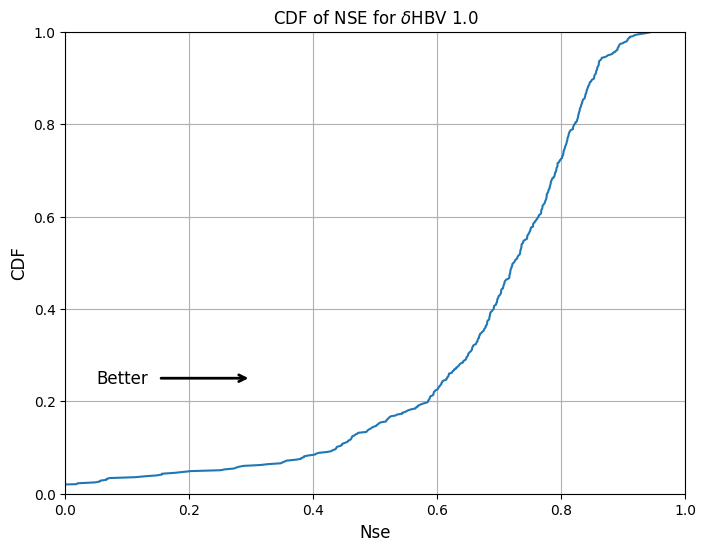

In [4]:
from dMG.core.post import plot_cdf

#------------------------------------------#
# Choose the metric to plot. (See available metrics printed above, or in the metrics_agg.json file).
METRIC = 'nse'
#------------------------------------------#



# 1. Load the evaluation metrics.
metrics_path = os.path.join(config['out_path'], 'metrics.json')
metrics = load_json(metrics_path)

# 2. Plot the CDF for NSE.
plot_cdf(
    metrics=[metrics],
    metric_names=[METRIC],
    model_labels=['dHBV 1.0'],
    title=r"CDF of NSE for $\delta$HBV 1.0",
    xlabel=METRIC.capitalize(),
    figsize=(8, 6),
    xbounds=(0, 1),
    ybounds=(0, 1),
    show_arrow=True
)

#### Generate the Spatial Plot

This plot shows the locations of each basin in the evaluation data, color-coded by performance on a metric. Here we give a plot for NSE, but as before, this metric can be changed to your preference. (See above; for metrics not valued between 0 and 1, you will need to set `dynamic_colorbar=True` in `geoplot_single_metric` to ensure proper coding.)

Note, you will need to add paths to the CAMELS shapefile, gage IDs, and 531-gage subset which can be found in the [CAMELS download](#before-running).

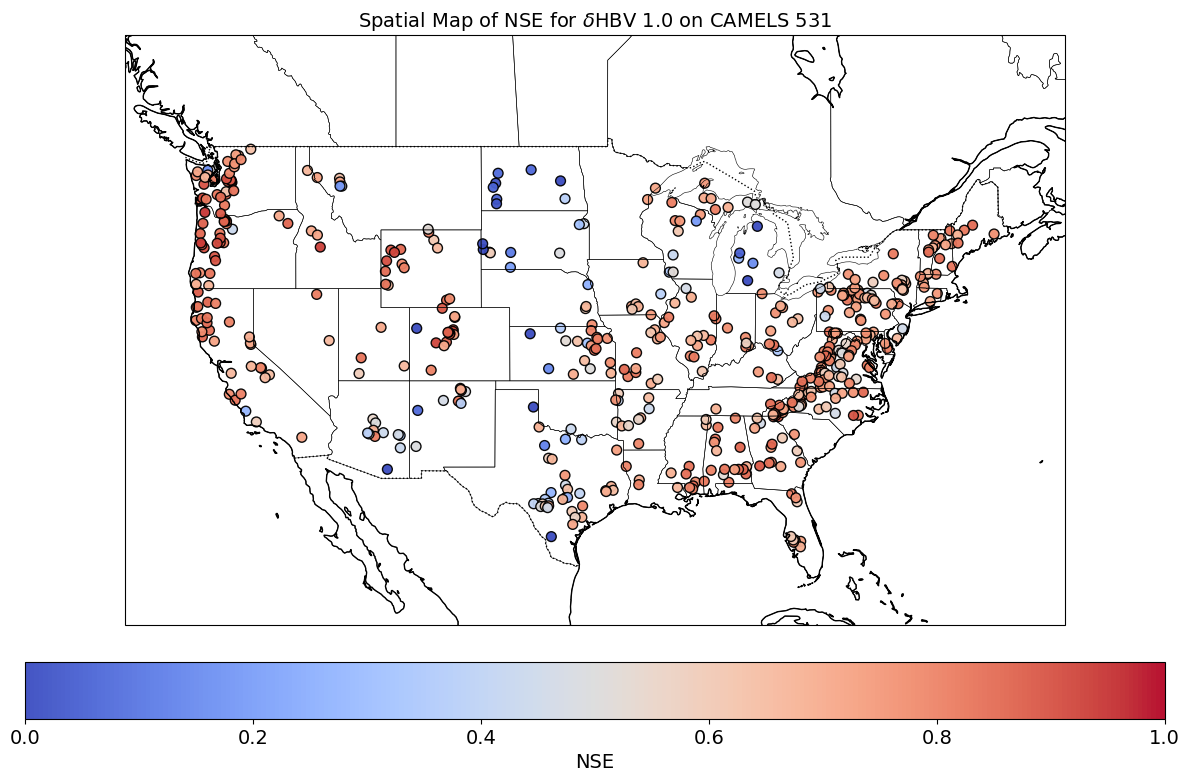

In [73]:
import geopandas as gpd
import numpy as np
import pandas as pd
from dMG.core.data import txt_to_array
from dMG.core.post import geoplot_single_metric

#------------------------------------------#
# Choose the metric to plot. (See available metrics printed above, or in the metrics_agg.json file).
METRIC = 'nse'

# Set the paths to the gage id lists and shapefiles...
GAGE_ID_PATH = '/projects/mhpi/leoglonz/project_silmaril/dMG/example/dHBV_1_0_trained_dev/gageid.npy' # 'your/path/to/gageid.npy'
GAGE_ID_531_PATH = '/projects/mhpi/leoglonz/project_silmaril/dMG/example/dHBV_1_0_trained_dev/Sub531ID.txt'  #'your/path/to/Sub531ID.txt'
SHAPEFILE_PATH = '/projects/mhpi/leoglonz/project_silmaril/dMG/example/dHBV_1_0_trained_dev/camels_loc/camels_671_loc.shp' #'your/path/to/camels_671_loc.shp'
#------------------------------------------#



# 2. Load gage ids + basin shapefile with geocoordinates (lat, long) for every gage.
gage_ids = np.load(GAGE_ID_PATH, allow_pickle=True)
gage_ids_531 = txt_to_array(GAGE_ID_531_PATH)
coords = gpd.read_file(SHAPEFILE_PATH)

# 3. Format geocoords for 531- and 671-basin CAMELS sets.
coords_531 = coords[coords['gage_id'].isin(list(gage_ids_531))].copy()

coords['gage_id'] = pd.Categorical(coords['gage_id'], categories=list(gage_ids), ordered=True)
coords_531['gage_id'] = pd.Categorical(coords_531['gage_id'], categories=list(gage_ids_531), ordered=True)

coords = coords.sort_values('gage_id')  # Sort to match order of metrics.
basin_coords_531 = coords_531.sort_values('gage_id')

# 4. Load the evaluation metrics.
metrics_path = os.path.join(config['out_path'], 'metrics.json')
metrics = load_json(metrics_path)

# 5. Add the evaluation metrics to the basin shapefile.
if config['observations']['name'] == 'camels_671':
    coords[METRIC] = metrics[METRIC]
    full_data = coords
elif config['observations']['name'] == 'camels_531':
    coords_531[METRIC] = metrics[METRIC]
    full_data = coords_531
else:
    raise ValueError(f"Observation data supported: 'camels_671' or 'camels_531'. Got: {config['observations']}")

# 6. Plot the evaluation results spatially.
geoplot_single_metric(
    full_data,
    METRIC,
    rf"Spatial Map of {METRIC.upper()} for $\delta$HBV 1.0 on CAMELS " \
        f"{config['observations']['name'].split('_')[-1]}",
    dynamic_colorbar=False,
)

## 4. Forward δHBV 1.0

This is an abbreviation of the forward demonstration in [1.3](#13-demonstration). Be sure to complete [these](#before-running) steps before running.

Note:
- The settings defined in `../example/conf/config_dhbv_1_0.yaml` are set to replecate benchmark performance.
- The default inference window is set from 1 October 2012 to 30 September 2014, which should use ~2.7GB of vram.
- The first year (`warm_up` in the config, 365 days is default) of the inference period is used for initializing HBV's internal states (water storages) and is, therefore, excluded from the model's prediction output.

In [ ]:
import sys

sys.path.append('../../')
sys.path.append('../../dMG')  # Add the dMG root directory.

from core.utils import print_config
from core.utils.factory import import_data_loader
from example import load_config
from models.model_handler import ModelHandler as dHBV

#------------------------------------------#
# Define model settings here.
CONFIG_PATH = '../example/conf/config_dhbv_1_1p.yaml'
#------------------------------------------#



# 1. Load configuration dictionary of model parameters and options.
config = load_config(CONFIG_PATH)
config['mode'] = 'predict'  # <-- Confirm that we are doing training if not set in the config file.
print_config(config)

# 2. Initialize the differentiable HBV 1.0 model (LSTM + HBV 1.0).
model = dHBV(config, verbose=True)

# 3. Load and initialize a dataset dictionary of NN and HBV model inputs.
data_loader_cls = import_data_loader(config['data_loader'])
data_loader = data_loader_cls(config, test_split=False, overwrite=False)

# 4. Forward the model to get the predictions.
predictions = model.forward(
    data_loader.dataset,
    eval=True
)

### Visualizing Model Predictions

After running model inference we can, e.g., view the hydrograph for one of the basins to see we are getting expected outputs.

We can do this with our target variable, streamflow, for instance... (though, there are many other states and fluxes we can output as shown in the output cell below.)

In [ ]:
import numpy as np
from core.data import txt_to_array
from core.post.plot_hydrograph import plot_hydrograph
from core.utils.dates import Dates

#------------------------------------------#
# Choose a basin by USGS gage ID to plot.
GAGE_ID = 1022500
TARGET = 'flow_sim'

# Resample to 3-day prediction. Options: 'D', 'W', 'M', 'Y'.
RESAMPLE = '3D'

# Set the paths to the gage ID lists...
GAGE_ID_PATH = 'your/path/to/gageid.npy'
GAGE_ID_531_PATH = 'your/path/to/Sub531ID.txt'
#------------------------------------------#



print(f"HBV states and fluxes: {predictions['HBV_1_1p'].keys()} \n")


# 1. Get the streamflow predictions and daily timesteps of the prediction window.
pred = predictions['HBV_1_1p'][TARGET]
timesteps = Dates(config['predict'], config['dpl_model']['rho']).batch_daily_time_range

# Remove warm-up period to match model output (see Note above.)
timesteps = timesteps[config['dpl_model']['phy_model']['warm_up']:]


# 2. Load the gage ID lists and get the basin index.
gage_ids = np.load(GAGE_ID_PATH, allow_pickle=True)
gage_ids_531 = txt_to_array(GAGE_ID_531_PATH)

print(f"First 20 available gage IDs: \n {gage_ids[:20]} \n")
print(f"First 20 available gage IDs (531 subset): \n {gage_ids_531[:20]} \n")

if config['observations']['name'] == 'camels_671':
    if GAGE_ID in gage_ids:
        basin_idx = list(gage_ids).index(GAGE_ID)
    else:
        raise ValueError(f"Basin with gage ID {GAGE_ID} not found in the CAMELS 671 dataset.")

elif config['observations']['name'] == 'camels_531':
    if GAGE_ID in gage_ids_531:
        basin_idx = list(gage_ids_531).index(GAGE_ID)
    else:
        raise ValueError(f"Basin with gage ID {GAGE_ID} not found in the CAMELS 531 dataset.")
else:
    raise ValueError(f"Observation data supported: 'camels_671' or 'camels_531'. Got: {config['observations']}")


# 3. Get the data for the chosen basin and plot.
streamflow_pred_basin = pred[:, basin_idx].squeeze()

plot_hydrograph(
    timesteps,
    streamflow_pred_basin,
    streamflow_pred_basin,
    resample=RESAMPLE,
    title=f"Hydrograph for Gage ID {GAGE_ID}",
    ylabel='Streamflow (ft$^3$/s)',
)